In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'BreastCancer'

Mounted at /content/gdrive


In [ ]:
base_dir

'/content/gdrive/My Drive/BreastCancer'

In [ ]:
%cd /content/gdrive/My\ Drive/BreastCancer

/content/gdrive/My Drive/BreastCancer


In [ ]:
!unzip cancerData.zip

Archive:  cancerData.zip
replace Augmentation (1)/Benign/b_0_4605 (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Augmentation (1)/Benign/b_0_4605 (1).png  
  inflating: Augmentation (1)/Benign/b_0_5575 (1).png  
  inflating: Augmentation (1)/Benign/b_0_565.png  
  inflating: Augmentation (1)/Benign/b_102_1556.png  
  inflating: Augmentation (1)/Benign/b_102_7609.png  
  inflating: Augmentation (1)/Benign/b_102_8481.png  
  inflating: Augmentation (1)/Benign/b_103_2263.png  
  inflating: Augmentation (1)/Benign/b_103_4058.png  
  inflating: Augmentation (1)/Benign/b_103_4669.png  
  inflating: Augmentation (1)/Benign/b_103_873.png  
  inflating: Augmentation (1)/Benign/b_104_1432.png  
  inflating: Augmentation (1)/Benign/b_104_1924.png  
  inflating: Augmentation (1)/Benign/b_104_720.png  
  inflating: Augmentation (1)/Benign/b_105_3169.png  
  inflating: Augmentation (1)/Benign/b_105_841.png  
  inflating: Augmentation (1)/Benign/b_105_9450.png  
  inflating: Augmentati

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 #rgb channels

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/BreastCancer/Augmentation (1)",
     shuffle = True ,
     image_size = (IMAGE_SIZE , IMAGE_SIZE),
     batch_size = BATCH_SIZE
    
)

Found 2344 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Benign', 'Malignant', 'Normal']

In [ ]:
len(dataset)

74

In [ ]:
#details for 1st batch
for image_batch , label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 0 2 1 1 0 0 0 0 2 2 0 0 0 1 0 1 0 2 0 1 1 0 1 0 2 0 0 1 0 0]


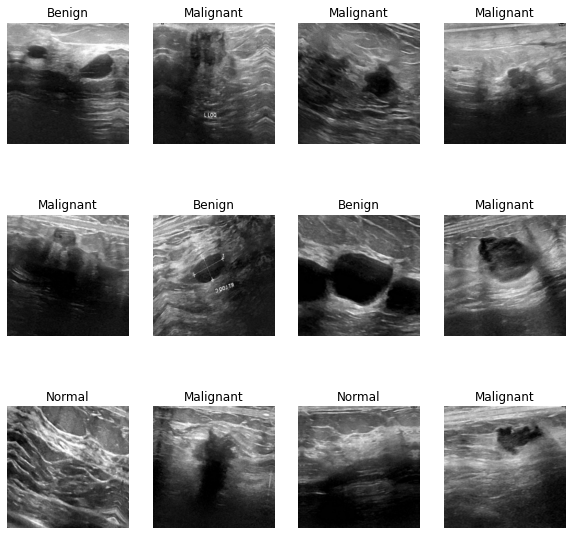

In [ ]:
#visualize data
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

**SPLITTING DATASET INTO TRAIN TEST SPLIT**
training = 80%
validation = 10%
testing = 10%


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds , val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

59

In [ ]:
len(val_ds)

7

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**Model Architecture**
We use a CNN coupled with a Softmax activation in the output layer. 


In [ ]:
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
59/59 [==============================] - 50s 358ms/step - loss: 0.9964 - accuracy: 0.5408 - val_loss: 0.8670 - val_accuracy: 0.6295
Epoch 2/50
59/59 [==============================] - 4s 67ms/step - loss: 0.8367 - accuracy: 0.6218 - val_loss: 0.7658 - val_accuracy: 0.6384
Epoch 3/50
59/59 [==============================] - 4s 67ms/step - loss: 0.7455 - accuracy: 0.6411 - val_loss: 0.6775 - val_accuracy: 0.7188
Epoch 4/50
59/59 [==============================] - 4s 67ms/step - loss: 0.6511 - accuracy: 0.7049 - val_loss: 0.6414 - val_accuracy: 0.7366
Epoch 5/50
59/59 [==============================] - 4s 67ms/step - loss: 0.5531 - accuracy: 0.7672 - val_loss: 0.5677 - val_accuracy: 0.7232
Epoch 6/50
59/59 [==============================] - 4s 68ms/step - loss: 0.4858 - accuracy: 0.7967 - val_loss: 0.3961 - val_accuracy: 0.8393
Epoch 7/50
59/59 [==============================] - 4s 67ms/step - loss: 0.4011 - accuracy: 0.8294 - val_loss: 0.4501 - val_accuracy: 0.8125
Epoch 8/50


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 16s 33ms/step - loss: 0.3937 - accuracy: 0.9570


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

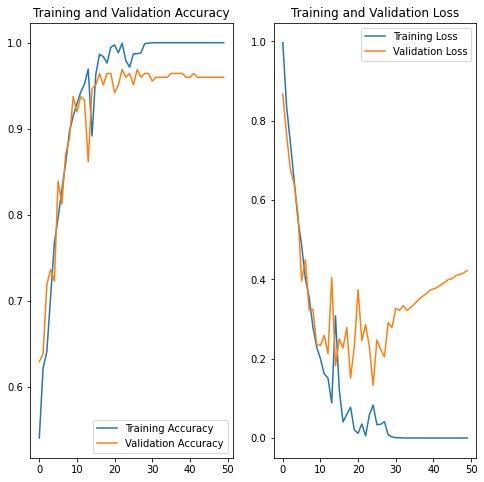

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict
Actual Label of predicted img: Benign
Predicted Label of img:  Benign


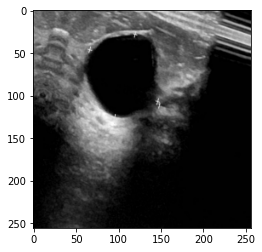

In [ ]:
for image_batch , label_batch in test_ds.take(1):
  first_img = image_batch[0].numpy().astype("uint8")
  first_label = label_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_img)
  print("Actual Label of predicted img:" , class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("Predicted Label of img: " , class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


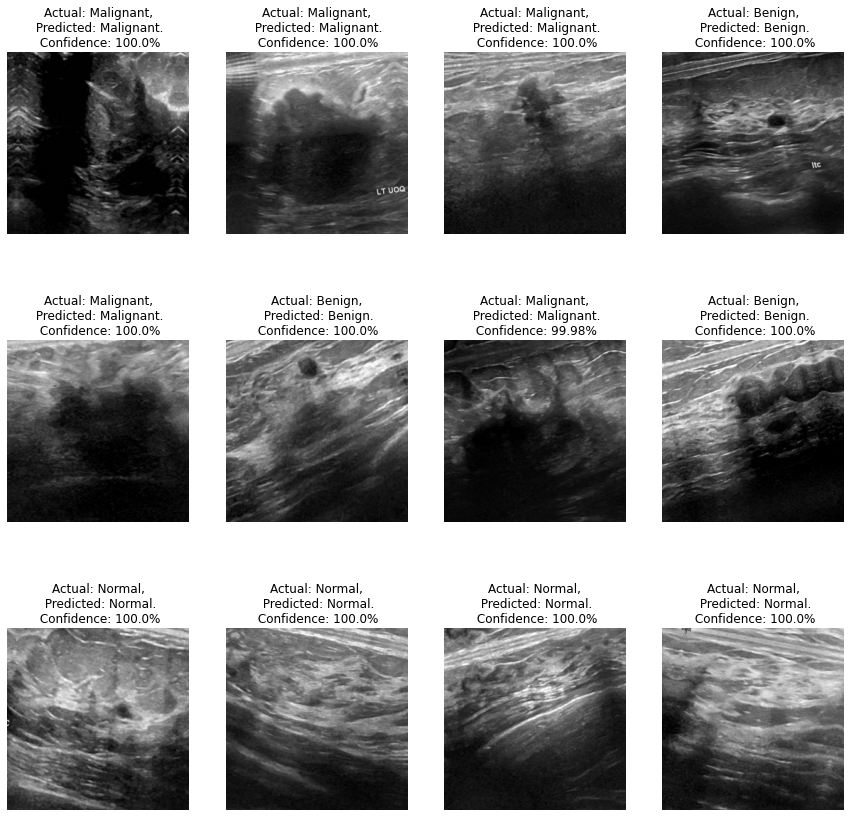

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(8):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model_version=max([int(i) for i in os.listdir("/content/gdrive/MyDrive/BreastCancer/model") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets
